In [1]:
#Auto-reload modules (used to develop functions outside this notebook)
%load_ext autoreload
%autoreload 2

In [38]:
import pyabf as abf #https://pypi.org/project/pyabf/
import matplotlib.pyplot as plt
from enum import Enum
from typing import List #for function annotations
import pims_nd2
import pandas as pd
import datetime
import pytz #for timezones
import numpy as np
import os

In [3]:
# Add 2p-py path
import sys
sys.path.append('../2p-py/')

In [4]:
# import modules from 2p-py
import labrotation.file_handling as file_handling
import labrotation.two_photon_session as two_photon_session
import labrotation.belt_processing as belt_processing

## Import session
- FIXME: session = two_photon_session.TwoPhotonSession... does not find specified files, asks in matlab prompt again for same files!
- TODO: once caiman analysis is done, can use h5 file/json parameters file to try and find the matching nd2 recording and data files!

In [5]:
matlab_2p_path = file_handling.open_dir("Choose matlab-2p folder!")

In [6]:
nd2_path = file_handling.open_file("Choose Nikon imaging file (.nd2)!")
nd2_meta_path = file_handling.open_file("Choose Nikon metadata file (.txt)!")
labview_path = file_handling.open_file("Choose LabView file (xy.txt, NOT xytime.txt)!")
labview_timestamps_path = labview_path[:-4] + "time.txt"
lfp_path = file_handling.open_file("Choose LFP file (.abf)!")

In [8]:
session = two_photon_session.TwoPhotonSession(nd2_path, nd2_meta_path, labview_path, labview_timestamps_path, lfp_path, matlab_2p_path)

Difference of starting times (s): 6.292987


#### Examples of contents

In [9]:
session.belt_dict.keys()

dict_keys(['round', 'speed', 'distance', 'distancePR', 'reflect', 'licking', 'stripes', 'stripesPR', 'time', 'timePR', 'reward', 'airpuff', 'soundl', 'soundr', 'odor1', 'odor2', 'odor3', 'odor4', 'odor5', 'pupil', 'tsscn', 'running', 'runtime', 'pupilLP', 'pupilraw'])

In [10]:
session.belt_scn_dict.keys()

dict_keys(['tsscn', 'rounds', 'speed', 'distance', 'totdist', 'running'])

In [11]:
session.lfp_df_cut

,t_mov_raw,t_mov_offset,t_mov_corrected,y_mov,y_mov_normalized,t_lfp_raw,t_lfp_offset,t_lfp_corrected,y_lfp
6293,6.293,0.000013,0.000013,2.447510,0.994946,6.293,0.000013,0.000013,0.223694
6294,6.294,0.001013,0.001017,2.459717,0.999908,6.294,0.001013,0.001017,0.216675
6295,6.295,0.002013,0.002021,2.452393,0.996930,6.295,0.002013,0.002021,0.226746
6296,6.296,0.003013,0.003024,2.455139,0.998047,6.296,0.003013,0.003024,0.220642
6297,6.297,0.004013,0.004028,2.456665,0.998667,6.297,0.004013,0.004028,0.217896
...,...,...,...,...,...,...,...,...,...
1182042,1182.042,1175.749013,1180.216859,2.479553,1.007972,1182.042,1175.749013,1180.216859,0.167542
1182043,1182.043,1175.750013,1180.217863,2.428284,0.987130,1182.043,1175.750013,1180.217863,0.164490
1182044,1182.044,1175.751013,1180.218867,2.482605,1.009212,1182.044,1175.751013,1180.218867,0.175476
1182045,1182.045,1175.752013,1180.219871,2.425232,0.985889,1182.045,1175.752013,1180.219871,0.164795


## Plot LFP movement and LabView movement data
The matching is done automatically. For T324 d1 16:34, the matching works. For issues, see GitHub issues.

In [29]:
session.shift_lfp(0  , match_type="zero")  # use shift_lfp() to correct matching issues

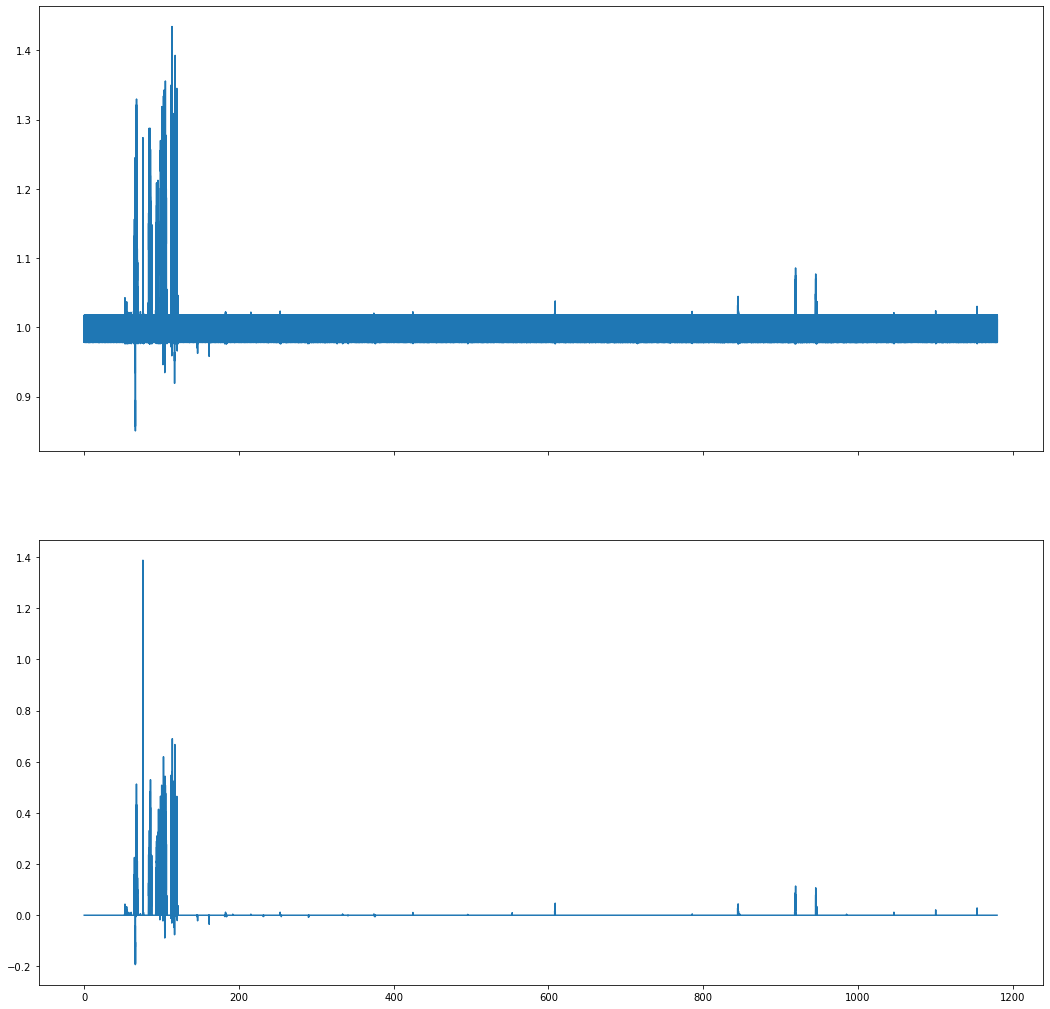

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(18, 18))

ax1.plot(session.lfp_df_cut.t_mov_corrected, session.lfp_df_cut.y_mov_normalized)
ax2.plot(session.belt_df["time_s"], session.belt_df["speed"])
#ax2.set_xlim([1112, 1115])
#ax2.set_xlim([780, 820])
plt.show()

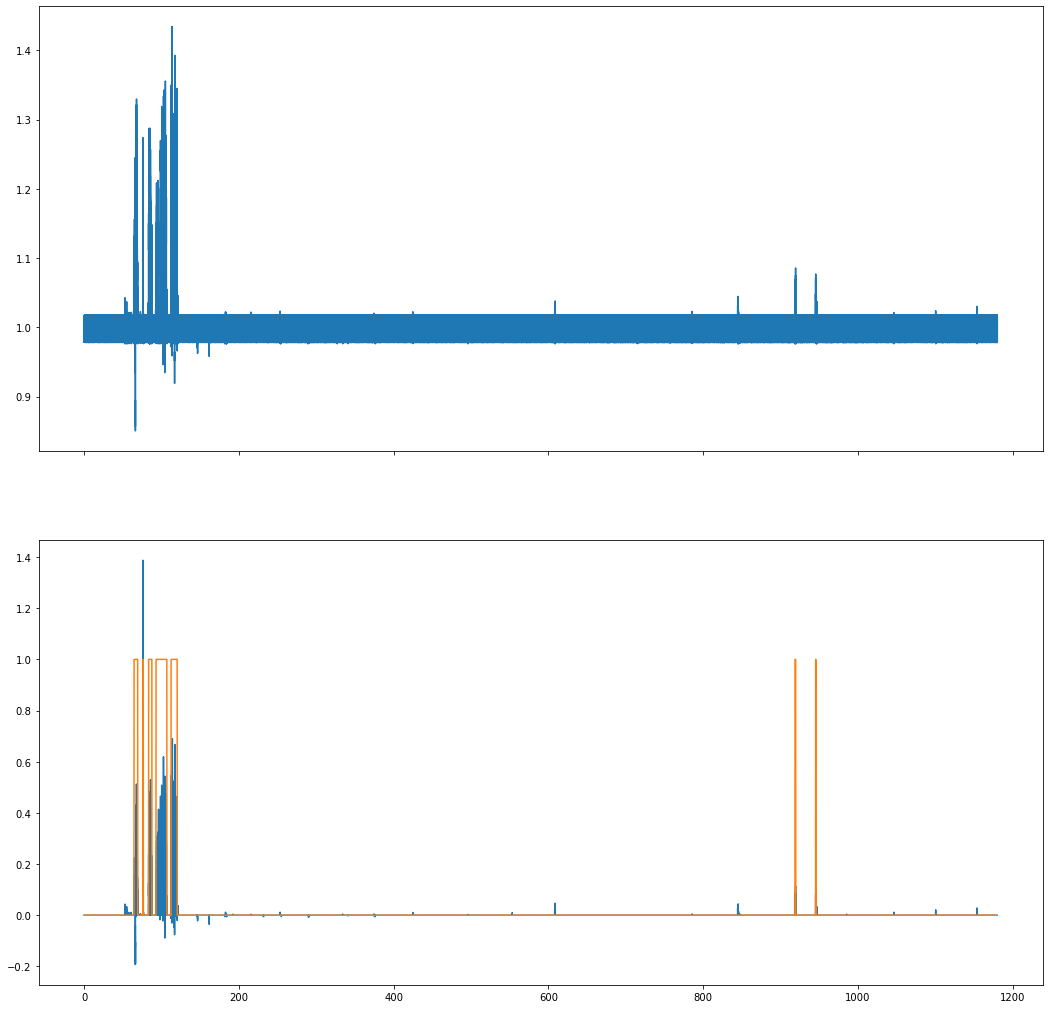

In [14]:
#plot with binary movement data
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(18, 18))

ax1.plot(session.lfp_df_cut.t_mov_corrected, session.lfp_df_cut.y_mov_normalized)
ax2.plot(session.belt_df["time_s"], session.belt_df["speed"])
ax2.plot(session.belt_df["time_s"], session.belt_df["running"])
plt.show()

In [16]:
xmi = 800
xma = 900
s = session.lfp_df_cut[(session.lfp_df_cut.t_mov_corrected >= xmi) & (session.lfp_df_cut.t_mov_corrected <= xma)].tail()

In [ ]:
session.belt_df

In [ ]:
s["y_mov_normalized"].idxmax()

In [ ]:
s.loc[s["y_mov_normalized"].idxmax()]

In [17]:
def plotWindowCompareMax(min_x, max_x):
    """
    Use this function to zoom in at bursts of movements, compare the max values 
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(18, 18))
    lfp_df_windowed = session.lfp_df_cut[(session.lfp_df_cut.t_mov_corrected >= min_x) & (session.lfp_df_cut.t_mov_corrected <= max_x)]
    lv_df_windowed = session.belt_df[ (session.belt_df.time_s >= min_x) & (session.belt_df.time_s <= max_x) ]
    lfp_max = lfp_df_windowed.loc[lfp_df_windowed["y_mov_normalized"].idxmax()].t_mov_corrected
    lv_max =   lv_df_windowed.loc[lv_df_windowed["speed"].idxmax()].time_s
    
    ax1.plot(lfp_df_windowed.t_mov_corrected, lfp_df_windowed.y_mov_normalized)
    ax1.axvline(lfp_max, color="r")
    ax2.plot(lv_df_windowed["time_s"], lv_df_windowed["speed"])
    ax2.axvline(lv_max, color="r")
    ax2.set_xlim([min_x, max_x])

    print(f"LFP max: { lfp_max }\nLV  max: {lv_max }\nAdd {lv_max - lfp_max} to LFP")
    plt.show()

## V2 of the function above

In [18]:
def plotWindowCompareMax(t_min, t_max):
    """
    v2. Use this function to zoom in at bursts of movements, compare the max values 
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(18, 18))

    # LFP first
    lfp_mov_t, lfp_mov_v = session.lfp_movement()
    # limit data to window
    lfp_mov_t_win = lfp_mov_t[(lfp_mov_t >= t_min) & (lfp_mov_t <= t_max)]
    lfp_mov_v_win = lfp_mov_v[lfp_mov_t_win.index]

    # find maximum of lfp data in window
    t_lfp_max = lfp_mov_t_win[lfp_mov_v_win.idxmax()]


    # LabView second
    lv_mov_t, lv_mov_v = session.labview_movement()

    lv_mov_t_win = lv_mov_t[(lv_mov_t >= t_min) & (lv_mov_t <= t_max)]
    lv_mov_v_win = lv_mov_v[lv_mov_t_win.index]

    t_lv_max = lv_mov_t_win[lv_mov_v_win.idxmax()]
    ax1.plot(lfp_mov_t_win, lfp_mov_v_win)
    ax1.axvline(t_lfp_max, color="r")
    ax2.plot(lv_mov_t_win, lv_mov_v_win)
    ax2.axvline(t_lv_max, color="r")
    ax2.set_xlim([t_min, t_max])

    print(f"LFP max: { t_lfp_max }\nLV  max: {t_lv_max }\nAdd {t_lv_max - t_lfp_max} to LFP")
    plt.show()

LFP max: 946.8181414848751
LV  max: 946.8182999999999
Add 0.00015851512478093355 to LFP


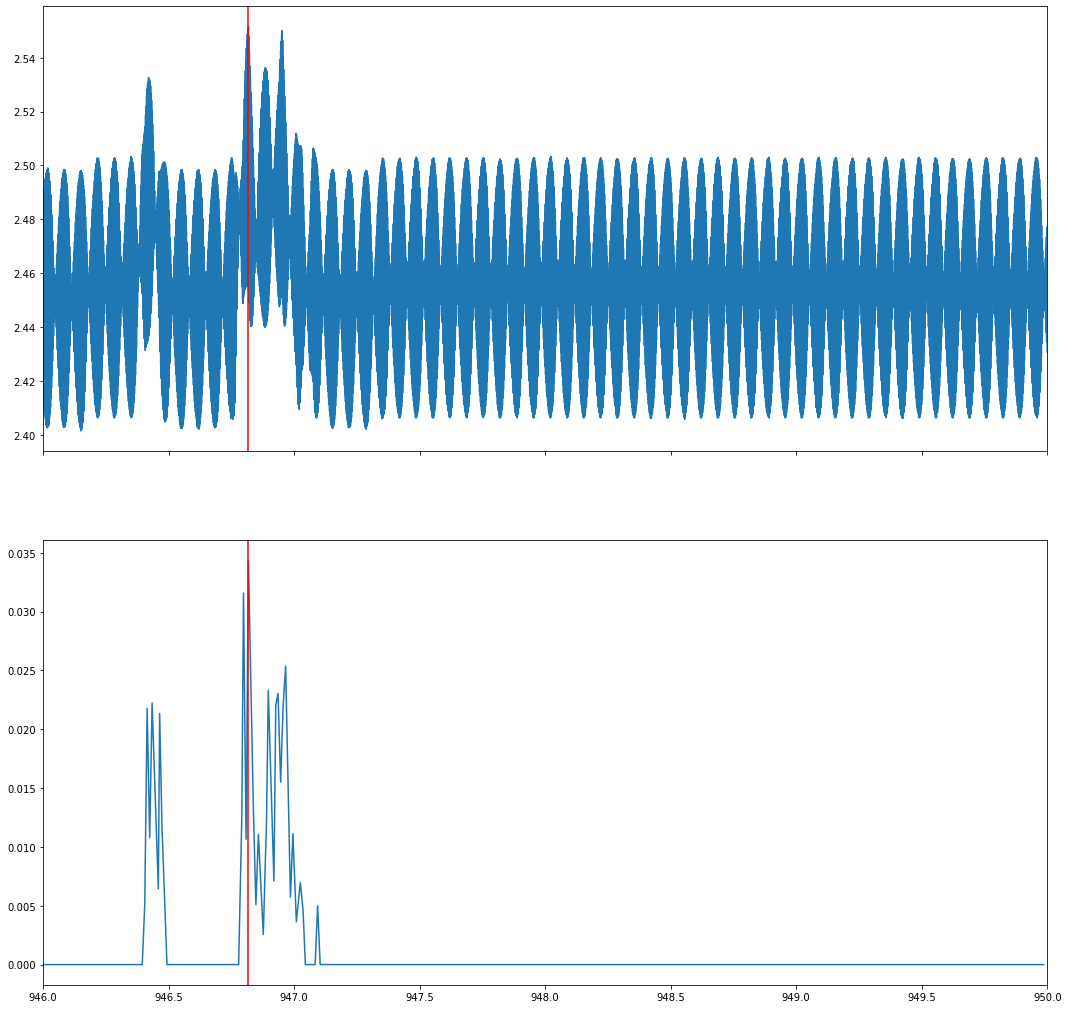

In [30]:
plotWindowCompareMax(946, 950)

### Save belt and matching parameters as JSON file

In [46]:
json_folder = file_handling.open_dir("Select folder to save json parameters (cancel to save to nd2 location)")
if json_folder == '.':
    json_folder, json_file = os.path.split(session.ND2_PATH)
    print(f"Automatically chose directory of nd2 file:\n{json_folder}")
else:
    _, json_file = os.path.split(session.ND2_PATH)
json_file = ".".join(json_file.split(".")[:-1]) + "_match_pars.json"
json_fpath = os.path.join(json_folder, json_file)
print(f"json file will be saved at nd2 location:\n{json_fpath}")

json file will be saved at nd2 location:
D:\Analysis data\T301\T301_tmev_d1\T301_tmev_d1.270820.1110_match_pars.json


In [47]:
session.export_json(fpath=json_fpath)

# Plot Nikon and LFP and movement together

In [ ]:
session.lfp_df_cut

In [ ]:
nikon_means = session.return_nikon_mean()

In [ ]:
nikon_t = session.nikon_daq_time

In [ ]:
fig = plt.figure()
plt.plot(nikon_t, nikon_means)
plt.show()

In [ ]:
xmin = 500
xmax = 750

fig, axs = plt.subplots(3, figsize=(18,18), gridspec_kw={'height_ratios': [2, 2, 1]}, sharex=True)
axs[0].plot(nikon_t, nikon_means, color="tab:green")  #nikon
axs[1].plot(session.lfp_df_cut.t_lfp_corrected, session.lfp_df_cut.y_lfp, color="tab:blue")  #lfp signal
axs[2].plot(session.lfp_df_cut.t_mov_corrected, session.lfp_df_cut.y_mov_normalized, color="tab:brown")  #lfp movement


axs[0].axes.yaxis.set_visible(False)
axs[1].axes.yaxis.set_visible(False)
axs[2].axes.yaxis.set_visible(False)
plt.xticks(fontsize=22)
plt.xlabel(xlabel="Time in recording (s)", fontsize=20)
plt.setp(axs[2], xlim=(xmin,xmax))
#plt.savefig("D:/PhD/Progress Reports/PR 1/Seizures/Figures/v2/NikLFPMov_NC.png", transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
xmin = 660
xmax = 665

fig, axs = plt.subplots(2, figsize=(18,18), gridspec_kw={'height_ratios': [2, 2]}, sharex=True)
axs[0].plot(nikon_t, nikon_means, color="tab:green")  #nikon
axs[1].plot(session.lfp_df_cut.t_lfp_corrected, session.lfp_df_cut.y_lfp, color="tab:blue")  #lfp signal

axs[0].axes.yaxis.set_visible(False)
axs[1].axes.yaxis.set_visible(False)
plt.xticks(fontsize=22)
plt.xlabel(xlabel="Time in recording (s)", fontsize=20)
plt.setp(axs[1], xlim=(xmin,xmax))

#plt.savefig("D:/PhD/Progress Reports/PR 1/Seizures/Figures/v2/NikLFPMov_CA1_IIS.png", transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
xmin = 10
xmax = 55

fig, axs = plt.subplots(3, figsize=(18,18), gridspec_kw={'height_ratios': [2, 2, 1]}, sharex=True)
axs[0].plot(nikon_t, nikon_means, color="tab:green")  #nikon
axs[1].plot(session.lfp_df_cut.t_lfp_corrected, session.lfp_df_cut.y_lfp, color="tab:blue")  #lfp signal
axs[2].plot(session.lfp_df_cut.t_mov_corrected, session.lfp_df_cut.y_mov_normalized, color="tab:brown")  #lfp movement


axs[0].axes.yaxis.set_visible(False)
axs[1].axes.yaxis.set_visible(False)
axs[2].axes.yaxis.set_visible(False)
plt.xticks(fontsize=22)
plt.xlabel(xlabel="Time in recording (s)", fontsize=20)
plt.setp(axs[2], xlim=(xmin,xmax))

#plt.savefig("D:/PhD/Progress Reports/PR 1/Seizures/Figures/v2/NikLFPMov_NC_zoomed.png", transparent=True, bbox_inches="tight")

plt.show()

In [ ]:
duration = 2  # in sec
refreshPeriod = 100  # in ms

fig, ax = plt.subplots()
vl = ax.axvline(0, ls='-', color='r', lw=1, zorder=10)
ax.set_xlim(0, duration)


def animate(i, vl, period):
    t = xmin + i*period / 1000
    vl.set_xdata([t, t])
    return vl,


ani = FuncAnimation(fig, animate, frames=int(
    duration/(refreshPeriod/1000)), fargs=(vl, refreshPeriod), interval=refreshPeriod)
plt.show()


### Experimenting with data (ChR2 experiments)

In [ ]:
for k, v in session.belt_dict.items():
    print(f"{k}: {len(v)}")

In [ ]:
for k, v in session.belt_scn_dict.items():
    print(f"{k}: {len(v)}")

In [ ]:
import nikon_ts_reader

In [ ]:
n_ts = nikon_ts_reader.standardize_stamp_file(nd2_meta_path, nd2_meta_path[:-4] + "_corrected.txt")

In [ ]:
nd2_meta_path[:-4] + "_corrected.txt"

In [ ]:
frames_means = session.return_nikon_mean()

In [ ]:
session.nikon_movie

In [ ]:
session.lfp_df_cut

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(18, 18))

ax1.plot()
ax2.plot(session.lfp_df_cut.t_mov_corrected, session.lfp_df_cut.y_mov_normalized)
ax3.plot(session.belt_df["time_s"], session.belt_df["speed"])
#ax2.set_xlim([1112, 1115])
#ax2.set_xlim([780, 820])
plt.show()

In [ ]:
type(session.nikon_daq_time)

In [ ]:

def plot3(x_min, x_max, savefig_fpath):
    cmap = plt.get_cmap("tab10")  # use default color map
    t_stim = 300.3605  # found first stim frame and corresponding NIDAQ time stamp (session.nikon_daq_time)
    t_stim_end = 305.3493
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(18, 20))
    l1, = ax1.plot(session.nikon_daq_time, frames_means, label="2p mean raw F", color=cmap(0))
    l2, = ax2.plot(session.lfp_df_cut.t_lfp_corrected, session.lfp_df_cut.y_lfp, label="LFP", color=cmap(1))
    l3, = ax3.plot(session.belt_df["time_s"], session.belt_df["speed"], label="Mouse speed", color=cmap(2))
    
    ax1.set_ylim([47.0, 50.0])
    ax3.set_xlabel("Time (s)", fontsize=16)
    #ax1.set_title("CA1 induction of SD", fontsize=20)
    plt.legend([l1, l2, l3], ["2p mean F", "LFP", "Mouse speed"], fontsize=20)
    
    ax1.set_yticks([],[])
    ax2.set_yticks([],[])
    ax3.set_yticks([],[])
    
    ax1.axvline(x=t_stim, color=cmap(3))
    ax2.axvline(x=t_stim, color=cmap(3))
    ax3.axvline(x=t_stim, color=cmap(3))
    
    ax1.axvline(x=t_stim_end, color=cmap(3))
    ax2.axvline(x=t_stim_end, color=cmap(3))
    ax3.axvline(x=t_stim_end, color=cmap(3))
    
    if x_min >= 0 and x_max > 0:
        ax3.set_xlim((x_min, x_max))
    if savefig_fpath != "":
        print(f"saving as {savefig_fpath}")
        plt.savefig(savefig_fpath, facecolor="w")
    plt.show()

In [ ]:
plot3(-1, -1, "D:/PhD/pres_22032022/extra/T413/plot_whole.png") #  

In [ ]:
plot3(298, 450, "D:/PhD/pres_22032022/extra/T413/plot_zoom.png")

In [ ]:
frames_means[15*299:16*300]

In [ ]:
for i in range(len(frames_means)):
    if frames_means[i] > 50:
        print(i)
        break

In [ ]:
# session.nikon_daq_time[4572]  # beginning of stim
session.nikon_daq_time[4649]  # end of stim frame

In [ ]:
for i in range(4580, len(frames_means)):
    if frames_means[i] < 30:
        print(i)
        print(frames_means[i])
        break

In [ ]:
session.ND2_PATH

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
l, = ax.plot([0,2*np.pi],[-1,1])

animate = lambda i: l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))

plt.show()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["animation.html"] = "jshtml"
import matplotlib.animation
import numpy as np

t = np.linspace(0,2*np.pi)
x = np.sin(t)

fig, ax = plt.subplots()
l, = ax.plot([0,2*np.pi],[-1,1])

animate = lambda i: l.set_data(t[:i], x[:i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(t))
ani

In [ ]:
%matplotlib qt